In [ ]:
import os
import random
from PIL import Image

import pathlib
import zipfile

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from typing import Tuple, Dict, List

In [ ]:
data_path = pathlib.Path("data/")
image_path = pathlib.Path("data/images")

if image_path.is_dir():
  print(f"[INFO] {image_path} already exists, skipping dowload.")
else:
  image_path.mkdir(parents = True, exist_ok = True)
  print(f"[INFO] {image_path} creating...")

with zipfile.ZipFile("data/brain_xray.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

[INFO] data/images creating...


In [ ]:
train_dir = pathlib.Path("data/images/brain_xray/train_folder")
test_dir = pathlib.Path("data/images/brain_xray/test_folder")

print(train_dir)
print(test_dir)

data/images/brain_xray/train_folder
data/images/brain_xray/test_folder


Brain Class Name: meningioma_tumor


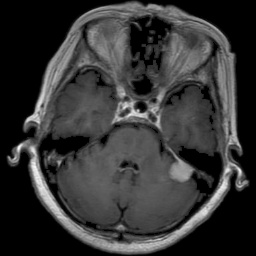

In [ ]:
image_path_list = list(pathlib.Path("data/images/brain_xray").glob("*/*/*.jpg"))

random_sample = random.choice(image_path_list)
image= Image.open(random_sample)
image_class_name = random_sample.parent.stem
print(f"Brain Class Name: {image_class_name}")
image

In [ ]:
class ImageFolder(torch.utils.data.Dataset):
  def __init__(self, root, transform):
    self.path = list(pathlib.Path(root).glob("*/*.jpg"))
    self.transform = transform
    self.classes = sorted([empty.name for empty in os.scandir(root)])
    self.class_to_idx = {class_name : i for i, class_name in enumerate(self.classes)}

  def load_image(self, index):
    image = self.path[index]
    return Image.open(image)

  def __len__(self):
    return len(self.path)

  def __getitem__(self, index):
    image = self.load_image(index)
    class_name = self.path[index].parent.stem
    class_to_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(image), class_to_idx
    else:
      return image, class_to_idx

In [ ]:
custom_test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224))
])

custom_train_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.TrivialAugmentWide()
])

custom_train_set = ImageFolder(root = pathlib.Path("data/images/brain_xray/train_folder"), transform = custom_train_transform)
custom_test_set = ImageFolder(root = pathlib.Path("data/images/brain_xray/test_folder"), transform = custom_test_transform)

print(custom_train_set.classes)
print(custom_train_set.class_to_idx)

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}


In [ ]:
def effnet_b0(classes : int = 4):
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  transform = weights.transforms()
  model = torchvision.models.efficientnet_b0(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  model.classifier = torch.nn.Sequential(
      torch.nn.Dropout(p = 0.3),
      torch.nn.Linear(in_features = 1280, out_features = classes)
  )
  return model, transform

In [ ]:
brain_xray_model, brain_xray_test_transform = effnet_b0()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s]


In [ ]:
brain_xray_train_transform = transforms.Compose([
  transforms.TrivialAugmentWide(),
  brain_xray_test_transform
])

In [ ]:
brain_xray_train_set = ImageFolder(root = pathlib.Path("data/images/brain_xray/train_folder"), transform = brain_xray_train_transform)
brain_xray_test_set = ImageFolder(root = pathlib.Path("data/images/brain_xray/test_folder"), transform = brain_xray_test_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 0.001

brain_xray_train_dataLoader = torch.utils.data.DataLoader(dataset = brain_xray_train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
brain_xray_test_dataLoader = torch.utils.data.DataLoader(dataset = brain_xray_test_set, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(brain_xray_model.parameters(), lr = LEARNING_RATE)

In [ ]:
def train_step(model : torch.nn.Module,
               train_dataLoader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               device : torch.device):

  total_train_loss, total_train_acc = 0, 0
  model.train()
  for batch, (X, y) in enumerate(train_dataLoader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    train_logits = model(X)
    train_loss = loss_fn(train_logits, y)
    total_train_loss += train_loss.item()
    train_loss.backward()
    optimizer.step()

    train_labels = torch.argmax(torch.softmax(train_logits, dim = 1), dim = 1)
    total_train_acc += (train_labels == y).sum().item() / len(train_labels)

  total_train_loss = total_train_loss / len(train_dataLoader)
  total_train_acc = total_train_acc / len(train_dataLoader)

  return total_train_loss, total_train_acc*100

def test_step(model : torch.nn.Module,
              test_dataLoader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              device : torch.device):

  total_test_loss, total_test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataLoader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      test_loss = loss_fn(test_logits, y)
      total_test_loss += test_loss.item()

      test_labels = torch.argmax(torch.softmax(test_logits, dim = 1), dim = 1)
      total_test_acc += (test_labels == y).sum().item() / len(test_labels)

    total_test_loss = total_test_loss / len(test_dataLoader)
    total_test_acc = total_test_acc / len(test_dataLoader)

  return total_test_loss, total_test_acc*100

def train_test(model : torch.nn.Module,
               train_dataLoader : torch.utils.data.DataLoader,
               test_dataLoader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               epochs : int,
               device : torch.device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  model.to(device)

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model = model,
                                       train_dataLoader = train_dataLoader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    test_dataLoader = test_dataLoader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
brain_xray_results = train_test(model = brain_xray_model,
                            train_dataLoader = brain_xray_train_dataLoader,
                            test_dataLoader = brain_xray_test_dataLoader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            epochs = 10,
                            device = "cuda" if torch.cuda.is_available() else "cpu")

brain_xray_results

Epoch: 1 | train_loss: 0.9962 | train_acc: 61.2871 | test_loss: 0.8504 | test_acc: 65.8443
Epoch: 2 | train_loss: 0.7181 | train_acc: 74.1724 | test_loss: 0.7336 | test_acc: 72.2588
Epoch: 3 | train_loss: 0.6342 | train_acc: 76.5411 | test_loss: 0.6877 | test_acc: 73.4101
Epoch: 4 | train_loss: 0.6203 | train_acc: 77.2260 | test_loss: 0.6506 | test_acc: 76.4803
Epoch: 5 | train_loss: 0.6106 | train_acc: 76.2842 | test_loss: 0.6236 | test_acc: 75.4386
Epoch: 6 | train_loss: 0.5770 | train_acc: 77.5828 | test_loss: 0.6088 | test_acc: 77.4671
Epoch: 7 | train_loss: 0.5696 | train_acc: 78.2962 | test_loss: 0.6084 | test_acc: 76.3158
Epoch: 8 | train_loss: 0.5488 | train_acc: 79.1809 | test_loss: 0.6013 | test_acc: 76.4803
Epoch: 9 | train_loss: 0.5550 | train_acc: 78.6672 | test_loss: 0.5823 | test_acc: 77.5219
Epoch: 10 | train_loss: 0.5355 | train_acc: 78.8670 | test_loss: 0.6302 | test_acc: 77.6864


{'train_loss': [0.9962371522433138,
  0.7181073872193898,
  0.6341609901761356,
  0.6203398459578213,
  0.6105551744160587,
  0.5770332923490707,
  0.5696049736787195,
  0.5488133944877206,
  0.5550079905006984,
  0.5355344186090443],
 'train_acc': [61.28710045662101,
  74.17237442922375,
  76.54109589041096,
  77.22602739726028,
  76.28424657534246,
  77.58276255707763,
  78.29623287671232,
  79.18093607305936,
  78.66723744292237,
  78.86700913242008],
 'test_loss': [0.850367684113352,
  0.7336415742572985,
  0.6876633371177473,
  0.6505920777195379,
  0.6236286053532049,
  0.6088025036611056,
  0.6084362064537249,
  0.6012741531196394,
  0.5823038745867578,
  0.6301956208128678],
 'test_acc': [65.84429824561403,
  72.25877192982456,
  73.41008771929825,
  76.48026315789474,
  75.43859649122807,
  77.4671052631579,
  76.31578947368422,
  76.48026315789474,
  77.5219298245614,
  77.68640350877193]}

In [ ]:
def plot_loss_curves(results):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]
  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label = "train loss")
  plt.plot(epochs, test_loss, label = "test loss")
  plt.title("Loss Table")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label = "train acc")
  plt.plot(epochs, test_acc, label = "test acc")
  plt.title("Accuracy Table")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

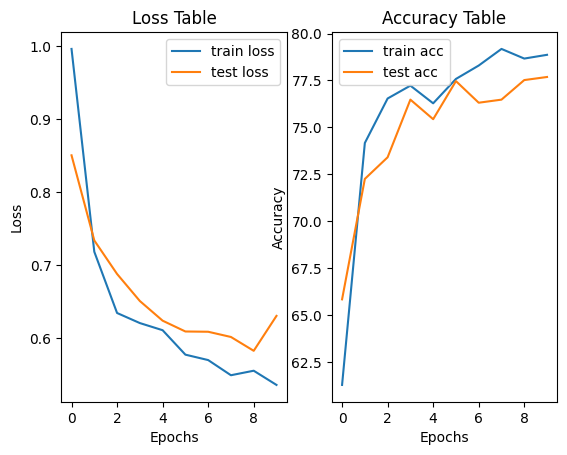

In [ ]:
plot_loss_curves(brain_xray_results)

In [ ]:
def save_model(model : torch.nn.Module,
               target_dir : str,
               model_name : str):

  target_dir_path = pathlib.Path(target_dir)
  target_dir_path.mkdir(parents = True, exist_ok = True)

  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model name should end with '.pth' pr '.pt'."

  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}.")
  torch.save(obj = model.state_dict(), f = model_save_path)

In [ ]:
save_model(model = brain_xray_model, target_dir = "model", model_name = "pretrained_effnet_b0_brain_xray.pth")

[INFO] Saving model to: model/pretrained_effnet_b0_brain_xray.pth.


In [ ]:
model_size = pathlib.Path("model/pretrained_effnet_b0_brain_xray.pth").stat().st_size // (1024 * 1024)
print(f"Model Size: {model_size} MB.")

Model Size: 15 MB.


In [ ]:
'''
pred_and_store function
return image_path, class_name, pred_prob, pred_class, time
'''
from timeit import default_timer as timer

def pred_and_store(model : torch.nn.Module,
                   transform : torch.nn.Module,
                   class_names : List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  results = []
  paths = list(pathlib.Path("data/images/brain_xray/test_folder").glob("*/*.jpg"))

  for path in paths:
    path_list = {}
    path_list["image_path"] = path
    class_name = path.parent.stem
    path_list["class_name"] = class_name
    image = Image.open(path)
    transformed_image = transform(image)
    unsqueezed_image = transformed_image.unsqueeze(0).to(device)

    start_time = timer()
    model.eval()
    with torch.inference_mode():
      pred_logit = model(unsqueezed_image)
      path_list["pred_prob"] = torch.softmax(pred_logit, dim = 1).max().cpu().item()
      pred_label = torch.argmax(torch.softmax(pred_logit, dim = 1), dim = 1)
    end_time = timer()
    path_list["time"] = round(end_time - start_time, 5)
    path_list["pred_class"]  =  class_names[pred_label]
    path_list["correct"] = class_name == class_names[pred_label]
    results.append(path_list)

  return results

In [ ]:
xray_brain_test_pred_dict = pred_and_store(model = brain_xray_model, transform = brain_xray_test_transform, class_names = brain_xray_test_set.classes, device = "cuda")

In [ ]:
xray_brain_test_pred_dict[90:95]

[{'image_path': PosixPath('data/images/brain_xray/test_folder/pituitary_tumor/P_155.jpg'),
  'class_name': 'pituitary_tumor',
  'pred_prob': 0.584065318107605,
  'time': 0.00919,
  'pred_class': 'meningioma_tumor',
  'correct': False},
 {'image_path': PosixPath('data/images/brain_xray/test_folder/pituitary_tumor/P_10.jpg'),
  'class_name': 'pituitary_tumor',
  'pred_prob': 0.6408772468566895,
  'time': 0.00935,
  'pred_class': 'meningioma_tumor',
  'correct': False},
 {'image_path': PosixPath('data/images/brain_xray/test_folder/pituitary_tumor/P_68.jpg'),
  'class_name': 'pituitary_tumor',
  'pred_prob': 0.9685307741165161,
  'time': 0.00897,
  'pred_class': 'pituitary_tumor',
  'correct': True},
 {'image_path': PosixPath('data/images/brain_xray/test_folder/pituitary_tumor/P_161.jpg'),
  'class_name': 'pituitary_tumor',
  'pred_prob': 0.9856126308441162,
  'time': 0.00907,
  'pred_class': 'pituitary_tumor',
  'correct': True},
 {'image_path': PosixPath('data/images/brain_xray/test_fold

In [ ]:
import pandas as pd
brain_xray_test_set_pd = pd.DataFrame(xray_brain_test_pred_dict)
brain_xray_test_set_pd.head()

,image_path,class_name,pred_prob,time,pred_class,correct
0,data/images/brain_xray/test_folder/normal/N_77...,normal,0.681865,0.01112,normal,True
1,data/images/brain_xray/test_folder/normal/N_68...,normal,0.932540,0.00919,normal,True
2,data/images/brain_xray/test_folder/normal/N_43...,normal,0.813124,0.01027,normal,True
3,data/images/brain_xray/test_folder/normal/N_29...,normal,0.969425,0.00905,normal,True
4,data/images/brain_xray/test_folder/normal/N_75...,normal,0.829582,0.00920,normal,True


In [ ]:
brain_xray_test_set_pd.correct.value_counts()

,count
correct,
True,466
False,134


In [ ]:
average_time_per_second = round(brain_xray_test_set_pd.pred_prob.mean(), 4)
print(f"Average time per second {average_time_per_second} seconds.")

Average time per second 0.7968 seconds.


-----------------------------------------------------------------

# Use ViT_B_16 Pretrained Model

In [ ]:
import torch.nn as nn
def vit_b_16(num_classes : int = 4, seed : int = 42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads  = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [ ]:
brain_xray_vitb16_model, brain_xray_vitb16_test_transforms = vit_b_16()

In [ ]:
brain_xray_vitb16_train_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),
    brain_xray_vitb16_test_transforms
])

In [ ]:
vitb16_train_set = ImageFolder(root = pathlib.Path("data/images/brain_xray/train_folder"), transform = brain_xray_vitb16_train_transforms)
vitb16_test_set = ImageFolder(root = pathlib.Path("data/images/brain_xray/test_folder"), transform = brain_xray_vitb16_test_transforms)

In [ ]:
vitb16_train_dataLoader = torch.utils.data.DataLoader(dataset = vitb16_train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers=NUM_WORKERS)
vitb16_test_dataLoader = torch.utils.data.DataLoader(dataset = vitb16_test_set, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

In [ ]:
vit_optimizer = torch.optim.Adam(params = brain_xray_vitb16_model.parameters(), lr = LEARNING_RATE)

In [ ]:
vitb16_results = train_test(model = brain_xray_vitb16_model,
                            train_dataLoader = vitb16_train_dataLoader,
                            test_dataLoader = vitb16_test_dataLoader,
                            loss_fn = loss_fn,
                            optimizer = vit_optimizer,
                            epochs = 10,
                            device = "cuda")
vitb16_results

Epoch: 1 | train_loss: 0.8433 | train_acc: 67.2232 | test_loss: 0.7078 | test_acc: 71.9846
Epoch: 2 | train_loss: 0.5557 | train_acc: 80.9075 | test_loss: 0.6073 | test_acc: 75.7675
Epoch: 3 | train_loss: 0.4826 | train_acc: 83.7043 | test_loss: 0.5689 | test_acc: 77.4123
Epoch: 4 | train_loss: 0.4481 | train_acc: 83.7757 | test_loss: 0.5687 | test_acc: 77.3026
Epoch: 5 | train_loss: 0.3982 | train_acc: 86.3156 | test_loss: 0.5133 | test_acc: 78.7281
Epoch: 6 | train_loss: 0.3843 | train_acc: 86.8008 | test_loss: 0.5145 | test_acc: 79.8246
Epoch: 7 | train_loss: 0.3797 | train_acc: 86.5154 | test_loss: 0.5018 | test_acc: 80.3728
Epoch: 8 | train_loss: 0.3681 | train_acc: 86.6296 | test_loss: 0.5073 | test_acc: 80.4825
Epoch: 9 | train_loss: 0.3427 | train_acc: 87.8567 | test_loss: 0.4977 | test_acc: 81.9627
Epoch: 10 | train_loss: 0.3275 | train_acc: 89.0126 | test_loss: 0.4827 | test_acc: 82.6754


{'train_loss': [0.843275684608172,
  0.5556807760914712,
  0.48257125812034085,
  0.44811679443267927,
  0.3981584957609438,
  0.3842507355833707,
  0.37974784186441607,
  0.36809217072513006,
  0.34274282479939394,
  0.3274571546544767],
 'train_acc': [67.22317351598173,
  80.90753424657534,
  83.70433789954338,
  83.77568493150685,
  86.31563926940639,
  86.80079908675799,
  86.5154109589041,
  86.62956621004567,
  87.85673515981736,
  89.01255707762557],
 'test_loss': [0.7078473928727602,
  0.607303942504682,
  0.5688614186487699,
  0.5687162413408882,
  0.5132563631785544,
  0.5145161544021807,
  0.5017681584546441,
  0.5073405888519789,
  0.4977265784614964,
  0.48272043309713664],
 'test_acc': [71.98464912280701,
  75.76754385964912,
  77.41228070175438,
  77.30263157894737,
  78.7280701754386,
  79.82456140350877,
  80.37280701754386,
  80.48245614035088,
  81.96271929824562,
  82.67543859649123]}

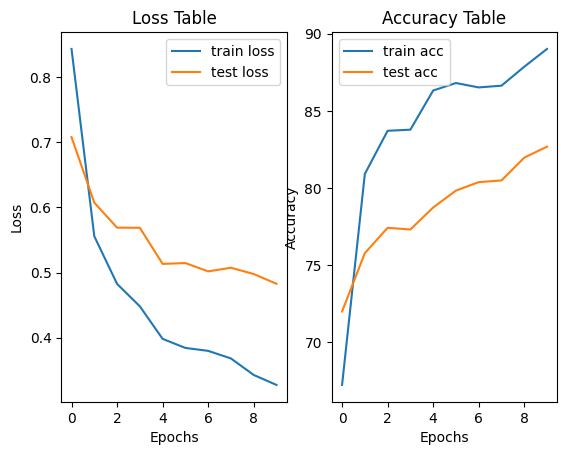

In [ ]:
plot_loss_curves(vitb16_results)

In [ ]:
save_model(model = brain_xray_vitb16_model, target_dir = "model", model_name = "pretrained_vit_b_16_brain_xray.pth")

[INFO] Saving model to: model/pretrained_vit_b_16_brain_xray.pth.


In [ ]:
xray_brain_test_pred_dict_vitb16 = pred_and_store(model = brain_xray_vitb16_model, transform = brain_xray_vitb16_test_transforms, class_names = vitb16_test_set.classes, device = "cuda")

In [ ]:
import pandas as pd
brain_xray_test_set_pd_vitb16 = pd.DataFrame(xray_brain_test_pred_dict_vitb16)
brain_xray_test_set_pd_vitb16.head()

,image_path,class_name,pred_prob,time,pred_class,correct
0,data/images/brain_xray/test_folder/normal/N_77...,normal,0.924708,0.02362,normal,True
1,data/images/brain_xray/test_folder/normal/N_68...,normal,0.962110,0.02245,normal,True
2,data/images/brain_xray/test_folder/normal/N_43...,normal,0.951461,0.02244,normal,True
3,data/images/brain_xray/test_folder/normal/N_29...,normal,0.999645,0.02241,normal,True
4,data/images/brain_xray/test_folder/normal/N_75...,normal,0.987035,0.02241,normal,True


In [ ]:
brain_xray_test_set_pd_vitb16.correct.value_counts()

,count
correct,
True,497
False,103


In [ ]:
average_time_per_second_vit_b16 = round(brain_xray_test_set_pd_vitb16.pred_prob.mean(), 4)
print(f"Average time per second {average_time_per_second_vit_b16} seconds.")

Average time per second 0.8189 seconds.


-----------------------------------------------------------------------------

In [ ]:
brain_xray_demo_path = pathlib.Path("demos/brain_xray")
brain_xray_demo_path.mkdir(parents = True, exist_ok = True)

brain_xray_demo_examples_path = brain_xray_demo_path / "examples"
brain_xray_demo_examples_path.mkdir(parents = True, exist_ok = True)

In [ ]:
import shutil
xray_names = ["glioma_tumor", "meningioma_tumor", "normal", "pituitary_tumor"]
xray_path = pathlib.Path("data/images/brain_xray/train_folder")
examples = []
for xray_name in xray_names:
  xray_brain_path = xray_path / xray_name
  path = list(xray_brain_path.glob("*.jpg"))
  random_image = random.choice(path)
  examples.append(random_image)

for random_brain_xray_image in examples:
  destination = brain_xray_demo_examples_path / random_brain_xray_image.name
  print(f"[INFO] Copying {random_brain_xray_image} to {destination}")
  shutil.copy2(random_brain_xray_image, destination)

[INFO] Copying data/images/brain_xray/train_folder/glioma_tumor/G_886.jpg to demos/brain_xray/examples/G_886.jpg
[INFO] Copying data/images/brain_xray/train_folder/meningioma_tumor/M_837.jpg to demos/brain_xray/examples/M_837.jpg
[INFO] Copying data/images/brain_xray/train_folder/normal/N_384.jpg to demos/brain_xray/examples/N_384.jpg
[INFO] Copying data/images/brain_xray/train_folder/pituitary_tumor/P_650.jpg to demos/brain_xray/examples/P_650.jpg


In [ ]:
!cp model/pretrained_effnet_b0_brain_xray.pth demos/brain_xray

In [ ]:
!cp model/pretrained_vit_b_16_brain_xray.pth demos/brain_xray

In [ ]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

In [ ]:
%%writefile demos/brain_xray/model.py

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

def vit_b_16_model(classes : int = 4):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transform = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  model.classifier = torch.nn.Sequential(
      torch.nn.Linear(in_features = 768, out_features = classes)
  )
  return model, transform

Overwriting demos/brain_xray/model.py


In [ ]:
%%writefile demos/brain_xray/app.py

import gradio as gr
import os
import torch

from model import vit_b_16_model
from timeit import default_timer as timer
from typing import Tuple, Dict

brain_xray_model, brain_xray_transforms = vit_b_16_model()

class_names = ["glioma_tumor", "meningioma_tumor", "normal", "pituitary_tumor"]

brain_xray_model.load_state_dict(
    torch.load(
        f = "pretrained_vit_b_16_brain_xray.pth",
        map_location = torch.device("cpu")
    )
)

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = brain_xray_transforms(img).unsqueeze(dim = 0)
  brain_xray_model.eval()
  with torch.inference_mode():
      y_logit = brain_xray_model(img)
      y_prob = torch.softmax(y_logit, dim = 1)

  pred_labels_and_probs = {class_names[i] : float(y_prob[0][i]) for i in range(len(class_names))}
  end_time = timer()
  pred_time = round(end_time - start_time, 5)

  return pred_labels_and_probs, pred_time

title = "Brain XRAY (GLIOMA - MENINGIOMA - NORMAL - PITUITARY)"
description = "An ViT B_16 feature extractor computer vision model to classify images of brain xray."
article = "train_loss: 0.3275 | train_acc: 89.0126 | test_loss: 0.4827 | test_acc: 82.6754"

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(
    fn = predict,
    inputs = gr.Image(type = "pil"),
    outputs = [gr.Label(num_top_classes = 5, label = "Predictions"),
               gr.Number(label = "Prediction Time (s)")
              ],
    examples = example_list,
    title = title,
    description = description,
    article = article
)

demo.launch()

Overwriting demos/brain_xray/app.py


In [ ]:
%%writefile demos/brain_xray/requirements.txt

torch==2.3.0
torchvision==0.18.0
transformers==4.41.1
gradio==4.35.0
numpy==1.26.4

Overwriting demos/brain_xray/requirements.txt


In [ ]:
!cd demos/brain_xray && zip -r ../brain_xray.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 51%)
  adding: examples/ (stored 0%)
  adding: examples/N_384.jpg (deflated 3%)
  adding: examples/M_837.jpg (deflated 1%)
  adding: examples/P_650.jpg (deflated 2%)
  adding: examples/G_886.jpg (deflated 2%)
  adding: model.py (deflated 49%)
  adding: pretrained_effnet_b0_brain_xray.pth (deflated 8%)
  adding: pretrained_vit_b_16_brain_xray.pth (deflated 7%)
  adding: requirements.txt (deflated 11%)


In [ ]:
try:
  from google.colab import files
  files.download("demos/brain_xray.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>